In [ ]:
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from transformers import BertTokenizer, BertModel, BertConfig

# Essential variables

In [ ]:
batch_size = 16

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

num_labels = 5

max_seq_len = 128

model_name = 'bert-large-uncased'

# Data processing

## Data preprocessing

In [ ]:
data = pd.read_csv("/content/dataset.csv")

In [ ]:
data["input_ids"] = data["input_ids"].apply(lambda x: list(map(lambda y: int(y), x.replace('[', '').replace(']', '').split(', '))))

In [ ]:
for i in range(5):
    data[f"{i+1}"] = (data['target'] == 1-0.5*i)
    data[f"{i+1}"] = data[f"{i+1}"].apply(int)

data["target"] = data.apply(lambda row: [row[f"{i}"] for i in range(1, 6)], axis=1)

In [ ]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

## Dataloader creation

In [ ]:
class NewsDataset(Dataset):
    def __init__(self, is_train=True):
        self.ds = train if is_train else test

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, ids):
        row = self.ds.iloc[ids]

        ids = torch.tensor(row['input_ids'], dtype=torch.long)
        mask = torch.ones(size=(1, max_seq_len), dtype=torch.long).squeeze(0)
        token_type_ids = torch.zeros(size=(1, max_seq_len), dtype=torch.long).squeeze(0)
        target = torch.tensor(row["target"], dtype=torch.float)

        return ids, mask, token_type_ids, target

In [ ]:
train_ds = NewsDataset()
test_ds = NewsDataset(False)

In [ ]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size)

# Model architecture

In [ ]:
class BERTClf(nn.Module):
    def __init__(self):
        super(BERTClf, self).__init__()
        self.num_labels = num_labels

        self.bert = BertModel.from_pretrained(model_name)
        self.reg = nn.Sequential(
            nn.Dropout(0.5),
            torch.nn.Linear(1024, num_labels),
            nn.Softmax(dim=1)
            )


    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.bert(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output = torch.tanh(self.reg(output_1))

        return output

    def freeze_weights(self):
        for p in self.bert.parameters():
            p.requires_grad = False

    def unfreeze_k_layers(self, k):
        bert_layers = list(list(list(next(self.children()).children())[1].children())[0].children())
        for i in range(len(bert_layers)-1, len(bert_layers)-1-k, -1):
            for p in bert_layers[i].parameters():
                p.requires_grad = True

In [ ]:
model = BERTClf().to(device)

# Train

In [ ]:
def train_func(model, train_data, test_data, loss_fct, epochs, optimizer, scheduler=None):
    acc_func = lambda x, y: sum(np.argmax(x.detach().cpu().numpy(), axis=1) == \
        np.argmax(y.detach().cpu().numpy(), axis=1)) / len(x)

    dataloaders = {
        "Train" : train_data["dataloader"],
        "Test" : test_data["dataloader"]
    }

    results = {
        "Train": {
            "max_acc": train_data["max_acc"],
            "loss" : [],
            "acc": [],
        },
        "Test": {
            "max_acc": test_data["max_acc"],
            "loss" : [],
            "acc": [],
        },

        "model_state": model.state_dict()
    }


    for epoch in range(epochs):
        epoch_data = {
            "Train": {
                "loss": 0.0,
                "acc" : 0.0,
            },
            "Test" : {
                "loss" : 0.0,
                "acc" : 0.0,
            }

        }
        for phase in ["Train", "Test"]:
            if phase == "Train":
                model.train()
            else:
                model.eval()

            with tqdm(dataloaders[phase], unit="batch") as tepoch:
                for step, batch in enumerate(tepoch):
                    tepoch.set_description(f"Epoch {epoch+1} Phase {phase}")

                    batch = [t.to(device) for t in batch]
                    input_ids, mask, token_type_ids, target = batch

                    logits = model(input_ids, mask, token_type_ids)

                    loss = loss_fct(logits, target)
                    acc = acc_func(logits, target)

                    epoch_data[phase]["loss"] += loss.item()
                    epoch_data[phase]["acc"] += acc

                    results[phase]["loss"].append(loss.item())
                    results[phase]["acc"].append(acc)

                    if phase == "Train":
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                        if scheduler is not None:
                            scheduler.step()

                    tepoch.set_postfix(loss=loss.item(), acc=acc, \
                                       avg_loss=epoch_data[phase]["loss"]/(step+1),
                                       avg_acc=epoch_data[phase]["acc"]/(step+1))

            epoch_data[phase]["loss"] /= (step+1)
            epoch_data[phase]["acc"] /= (step+1)

        if epoch_data["Test"]["acc"] > results["Test"]["max_acc"]:
            results["Test"]["max_acc"] = epoch_data["Test"]["acc"]
            results["Train"]["max_acc"] = epoch_data["Train"]["acc"]

        results["model_state"] = model.state_dict()


    print(f'Model saved with avg test accuracy: {results["Test"]["max_acc"]:.2f}')
    print(f'Avg train accuracy: {results["Train"]["max_acc"]:.2f}')


    return results

In [ ]:
model.freeze_weights()
model.unfreeze_k_layers(10)

loss_fct = nn.BCEWithLogitsLoss()

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-6, weight_decay=0.01)

In [ ]:
train_data = {
    "dataloader" : train_dl,
    "max_acc" : 0
}

test_data = {
    "dataloader" : test_dl,
    "max_acc" : 0
}

In [ ]:
epochs = 15
results = train_func(model, train_data, test_data, loss_fct, epochs, optimizer)

Epoch 2 Phase Train:  61%|██████    | 149/245 [01:50<01:11,  1.35batch/s, acc=0.5, avg_acc=0.458, avg_loss=0.719, loss=0.708]


KeyboardInterrupt: ignored

In [ ]:
model_state = results["model_state"]

In [ ]:
try:
    test_loss = test_loss + results["Test"]['loss']
    train_loss = train_loss + results["Train"]['loss']
    test_acc = test_acc + results["Test"]['acc']
    train_acc = train_acc + results["Train"]['acc']

except NameError:
    test_loss = results["Test"]['loss']
    train_loss = results["Train"]['loss']
    test_acc = results["Test"]['acc']
    train_acc = results["Train"]['acc']

In [ ]:
model.load_state_dict(model_state)

In [ ]:
gc.collect()

torch.cuda.empty_cache()

In [ ]:
def plot_metrics(metrics = [test_loss, train_loss, test_acc, train_acc], \
                 freq=[1, 1, 1, 1],
                 labels=["Test loss", "Train loss", "Test accuracy", "Train accuracy"],
                 colors=["crimson", "navy", "darkcyan", "forestgreen"]):

    plt.figure(figsize=[20, 9])

    for i in range(4):
        plt.subplot(2, 2, i+1).plot(range(len(metrics[i]))[::freq[i]], \
                        metrics[i][::freq[i]], color=colors[i])
        plt.title(labels[i])

    plt.suptitle("Training results")
    plt.show()

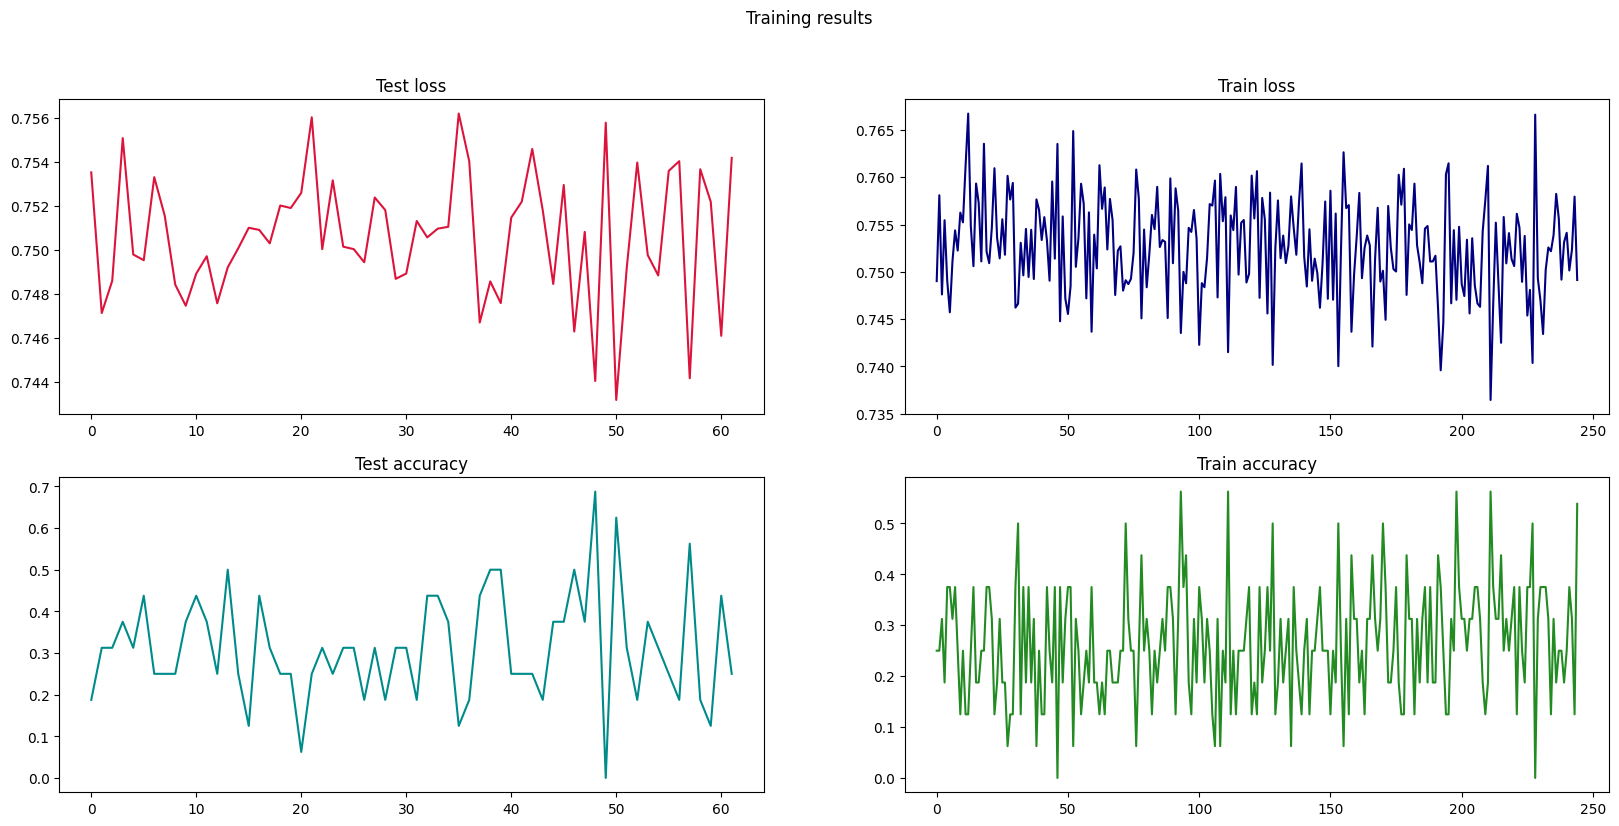

In [ ]:
plot_metrics()

In [ ]:
torch.save(results, "session_3.pth")